# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="https://github.com/Maxxx-zh/hopsworks-tutorials/blob/bitcoin/images/icon102.png?raw=1" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Model Training</span>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/bitcoin/4_model_training.ipynb)

## 🗒️ In this notebook you will see how to create and deploy a model using  Hopsworks Feature Store : 

1. Loading the training data.
2. Train the model.
3. Register model in Hopsworks model registry.
4. Online model deployment.
5. Using the deployment to make a prediciton.

![part3](https://github.com/Maxxx-zh/hopsworks-tutorials/blob/bitcoin/images/03_model.png?raw=1) 

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [1]:
!pip install -U hopsworks --quiet

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1152
Connected. Call `.close()` to terminate connection gracefully.


---
### <span style="color:#ff5f27;"> 📝 Imports</span>

In [3]:
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import warnings
warnings.filterwarnings('ignore')

---

## <span style="color:#ff5f27;">🪝 Feature View and Training Dataset Retrieval</span>

In [4]:
feature_view = fs.get_feature_view(
    name = 'bitcoin_feature_view',
    version = 1
)

In [5]:
X_train, _ = feature_view.get_training_data(1)
X_val, _ = feature_view.get_training_data(2)
X_test, _ = feature_view.get_training_data(3)

In [6]:
X_train[X_train.isnull().any(axis=1)].shape

(0, 35)

In [7]:
X_test[X_test.isnull().any(axis=1)].shape

(35, 35)

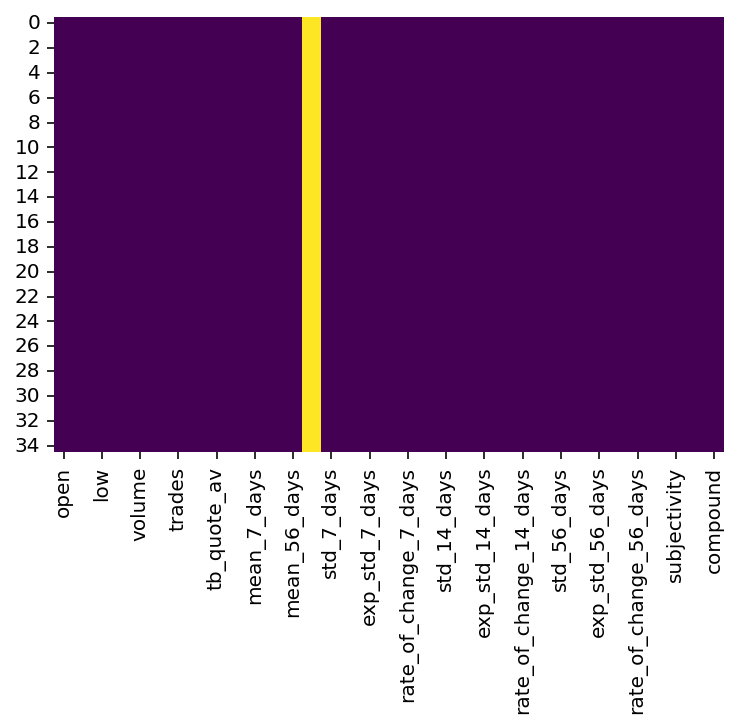

NUMBER OF NULL VALUES PER COLUMN:
open                       0
high                       0
low                        0
close                      0
volume                     0
quote_av                   0
trades                     0
tb_base_av                 0
tb_quote_av                0
unix                       0
mean_7_days                0
mean_14_days               0
mean_56_days               0
signal                    35
std_7_days                 0
exp_mean_7_days            0
exp_std_7_days             0
momentum_7_days            0
rate_of_change_7_days      0
strength_index_7_days      0
std_14_days                0
exp_mean_14_days           0
exp_std_14_days            0
momentum_14_days           0
rate_of_change_14_days     0
strength_index_14_days     0
std_56_days                0
exp_mean_56_days           0
exp_std_56_days            0
momentum_56_days           0
rate_of_change_56_days     0
strength_index_56_days     0
subjectivity               0
polarity 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X_test.isnull(),cbar=False,cmap='viridis')
plt.show()
print("\033[4mNUMBER OF NULL VALUES PER COLUMN:\033[0m")
print(X_test.isnull().sum())
cols_with_nan = X_test.columns[X_test.isna().any()].tolist()

In [9]:
X_test['signal'] = X_test['signal'].fillna(X_train['signal'].median())

In [10]:
X_val[X_val.isnull().any(axis=1)].shape

(0, 35)

In [11]:
X_train.head(3)

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,unix,...,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound
0,0.198037,0.204706,0.170926,0.202976,0.322023,0.306394,0.357038,0.340304,0.323565,1621634400000,...,0.348792,0.678404,0.709071,0.773587,0.224080,0.132846,0.721929,0.000000,0.000000,0.000000
1,0.045838,0.036163,0.061575,0.052688,0.052330,0.021755,0.009136,0.052718,0.020835,1626559200000,...,0.484015,0.254126,0.036783,0.711670,0.517580,0.269445,0.722445,0.470903,0.553118,0.463243
2,0.453786,0.481480,0.476383,0.506142,0.057658,0.076173,0.072897,0.064045,0.084403,1640037600000,...,0.526526,0.672097,0.771828,0.683662,0.355353,0.285952,0.763923,0.000000,0.000000,0.000000


In [12]:
# lets remove redundant column "unix"
X_train.drop(columns=["unix"], inplace=True)
X_val.drop(columns=["unix"], inplace=True)
X_test.drop(columns=["unix"], inplace=True)

In [48]:
y_train = X_train[["close"]]
y_val = X_val[["close"]]
y_test = X_test[["close"]]

---

## <span style="color:#ff5f27;">🤖 Time series model</span>

In [14]:
# Now lets define Tensorflow Dataset as we are going to train keras tensorflow model

def windowed_dataset(dataset, target, window_size, batch_size):
    ds = dataset.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.map(lambda window: tf.reshape(window[-1:], [-1, 34]))
        
    target_ds = target.window(window_size, shift=1, drop_remainder=True)
    target_ds = target_ds.flat_map(lambda window: window.batch(window_size))
    target_ds = target_ds.map(lambda window: window[-1:])
    
    ds = tf.data.Dataset.zip((ds, target_ds))
    ds = ds.batch(batch_size,True)
    ds = ds.prefetch(1)
    return ds

In [15]:
training_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(X_train.values, tf.float32)) 
training_target = tf.data.Dataset.from_tensor_slices(y_train.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
training_dataset = windowed_dataset(training_dataset, training_target, window_size=2, batch_size=16)
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [16]:
validation_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(X_val.values, tf.float32))
validation_target = tf.data.Dataset.from_tensor_slices(y_val.values.flatten().tolist()) 
training_dataset = training_dataset.repeat(500)
validation_dataset = windowed_dataset(validation_dataset, validation_target, window_size=2, batch_size=16)
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(16, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(16, None), dtype=tf.float32, name=None))>

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(X_test.values, tf.float32))
test_target = tf.data.Dataset.from_tensor_slices(y_test.values.flatten().tolist()) 
test_dataset = windowed_dataset(test_dataset, test_target, window_size=2, batch_size=1)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(1, None, 34), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None))>

In [18]:
def build_model(input_dim):
    inputs = tf.keras.layers.Input(shape=(input_dim[0],input_dim[1]))
    x = tf.keras.layers.Conv1D(filters = 128, kernel_size=1, padding='same', kernel_initializer="uniform")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = tf.keras.layers.Conv1D(filters = input_dim[1], kernel_size= 1,padding='same',  kernel_initializer="uniform")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)    
    x = tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)    

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(34, activation="relu", kernel_initializer="uniform")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation="relu", kernel_initializer="uniform")(x)
    
    model = tf.keras.Model(inputs, x)
    model.summary()
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [19]:
model = build_model([1, 34])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 34)]           0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4480      
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 128)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 34)             4386  

In [20]:
from timeit import default_timer as timer
start = timer()
history = model.fit(training_dataset,
                    epochs=10,
                    verbose=0,
                    steps_per_epoch=500,
                    validation_data=validation_dataset,
                    validation_steps=1,                    
                   )
end = timer()
print(end - start)

24.778637813000387


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

### <span style='color:#ff5f27'>👮🏻‍♂️ Model Validation</span>

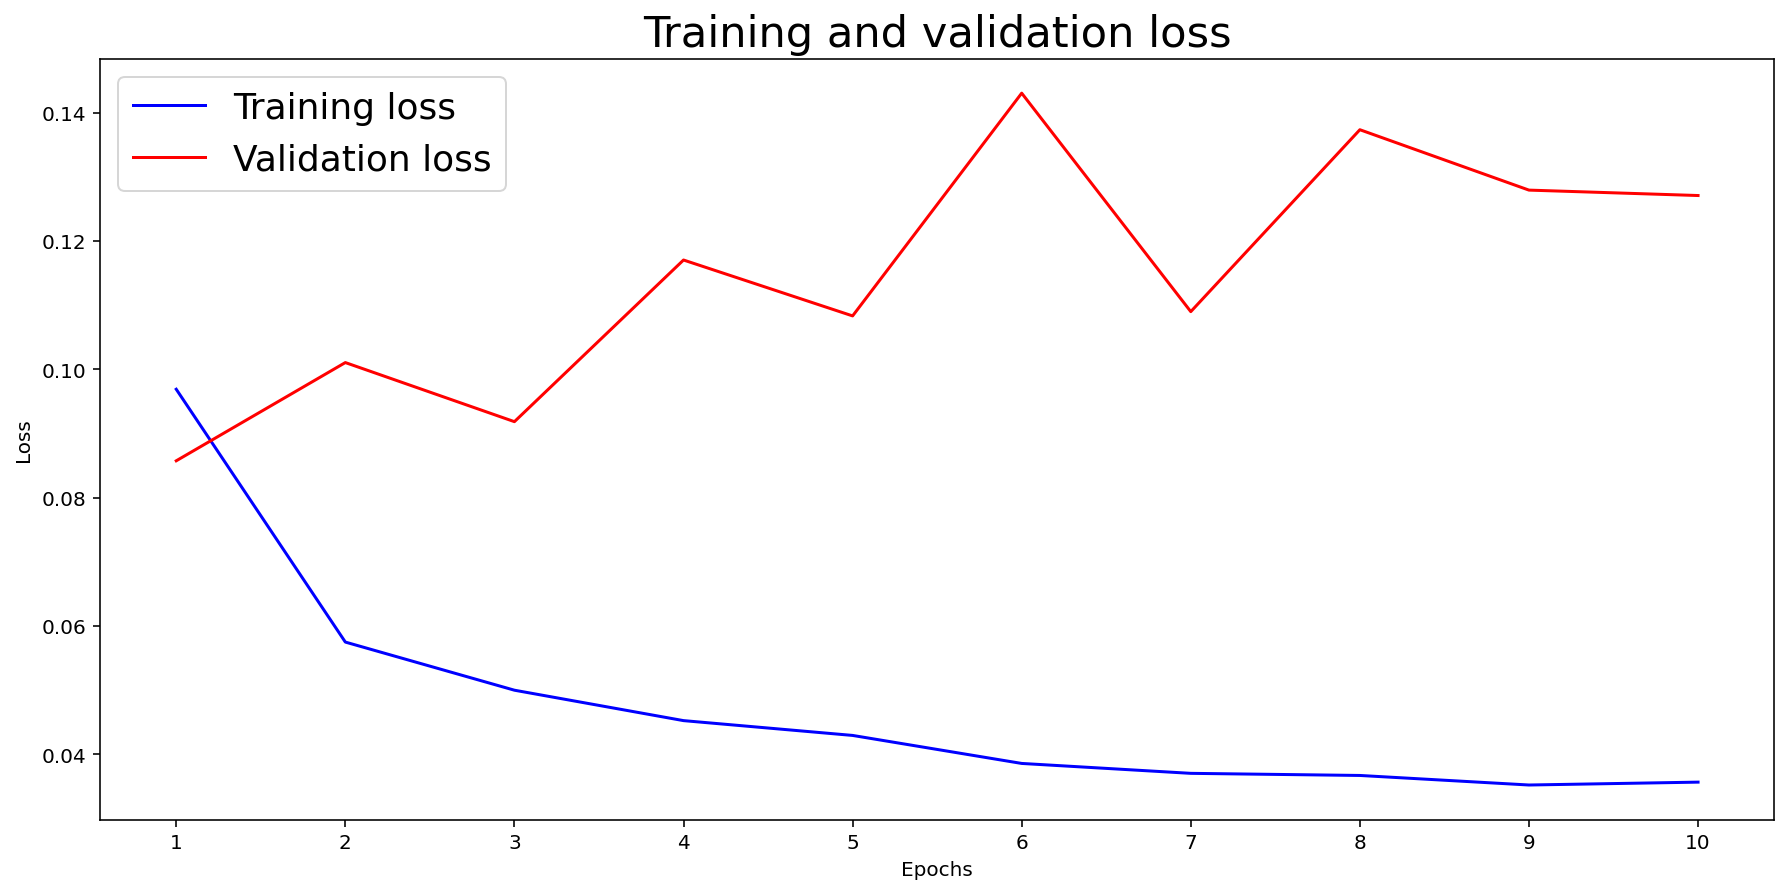

In [22]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']

loss_values50 = loss_values
val_loss_values50 = val_loss_values
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [50]:
y_pred = model.predict(X_test.values.reshape(-1, 1, 34))
y_pred[:5]

array([[0.18400736],
       [0.26439184],
       [0.9340491 ],
       [0.2049897 ],
       [0.60955715]], dtype=float32)

In [32]:
test = X_test.head(1)
test

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,mean_7_days,...,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound
0,0.036303,0.029911,0.188443,0.075794,0.035363,0.033177,0.005182,0.034943,0.033383,0.0,...,0.608023,0.907368,0.107113,0.993391,0.057887,0.047523,0.303466,0.323536,0.306013,0.315515


In [33]:
test["open"] = 0.1
test["high"] = 0.12
test["volume"] = 0.07

In [34]:
model.predict(test.values.reshape(-1, 1, 34))

array([[0.18400738]], dtype=float32)

In [50]:
from datetime import datetime
today = datetime.today().strftime("%Y-%m-%d")

target_unix = (int(pd.Timestamp(today).timestamp()) - 7200) * 1000# "-7200" is a temporary workaround.

print(target_unix)

1664402400000


In [60]:
help(feature_view.get_feature_vector)

Help on method get_feature_vector in module hsfs.feature_view:

get_feature_vector(entry: List[Dict[str, Any]], passed_features: Union[Dict[str, Any], NoneType] = {}, external: Union[bool, NoneType] = None) method of hsfs.feature_view.FeatureView instance
    Returns assembled serving vector from online feature store.
    
    # Arguments
        entry: dictionary of feature group primary key and values provided by serving application.
        passed_features: dictionary of feature values provided by the application at runtime.
            They can replace features values fetched from the feature store as well as
            providing feature values which are not available in the feature store.
        external: boolean, optional. If set to True, the connection to the
            online feature store is established using the same host as
            for the `host` parameter in the [`hsfs.connection()`](project.md#connection) method.
            If set to False, the online feature store

In [64]:
df, _ = feature_view.get_training_data(1)

In [65]:
df

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,unix,...,strength_index_14_days,std_56_days,exp_mean_56_days,exp_std_56_days,momentum_56_days,rate_of_change_56_days,strength_index_56_days,subjectivity,polarity,compound
0,0.198037,0.204706,0.170926,0.202976,0.322023,0.306394,0.357038,0.340304,0.323565,1621634400000,...,0.348792,0.678404,0.709071,0.773587,0.224080,0.132846,0.721929,0.000000,0.000000,0.000000
1,0.045838,0.036163,0.061575,0.052688,0.052330,0.021755,0.009136,0.052718,0.020835,1626559200000,...,0.484015,0.254126,0.036783,0.711670,0.517580,0.269445,0.722445,0.470903,0.553118,0.463243
2,0.453786,0.481480,0.476383,0.506142,0.057658,0.076173,0.072897,0.064045,0.084403,1640037600000,...,0.526526,0.672097,0.771828,0.683662,0.355353,0.285952,0.763923,0.000000,0.000000,0.000000
3,0.747299,0.727311,0.712717,0.693329,0.157401,0.252689,0.266268,0.160719,0.258373,1617746400000,...,0.590120,0.468318,0.849679,0.454136,0.783263,0.590659,0.940058,0.057716,0.048107,0.034499
4,0.182345,0.300198,0.161556,0.284514,0.549623,0.567222,0.633339,0.571954,0.590020,1621461600000,...,0.382908,0.581468,0.757288,0.673240,0.368081,0.193047,0.744395,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,0.329028,0.300102,0.325922,0.309297,0.078895,0.079428,0.152231,0.085967,0.086786,1627682400000,...,0.839329,0.304850,0.038086,0.622036,0.684792,0.583106,0.834363,0.000000,0.000000,0.000000
327,0.844883,0.825458,0.837712,0.823766,0.050973,0.103620,0.115763,0.051035,0.104797,1634335200000,...,0.848772,0.513176,0.587647,0.713807,0.800463,0.655291,0.957706,0.000000,0.000000,0.000000
328,0.737903,0.746105,0.755433,0.767347,0.109468,0.186767,0.160656,0.115490,0.197032,1617055200000,...,0.720943,0.000000,0.797190,0.474413,0.572084,0.436733,0.000000,0.000000,0.000000,0.000000
329,0.689717,0.672081,0.691840,0.688670,0.061635,0.104049,0.149723,0.063457,0.107377,1616882400000,...,0.650637,0.000000,0.780034,0.472947,0.572084,0.436733,0.000000,0.000000,0.000000,0.000000


In [70]:
# feature_vector = feature_view.get_feature_vector({"unix": '1624838400000'})

Exception: ignored

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

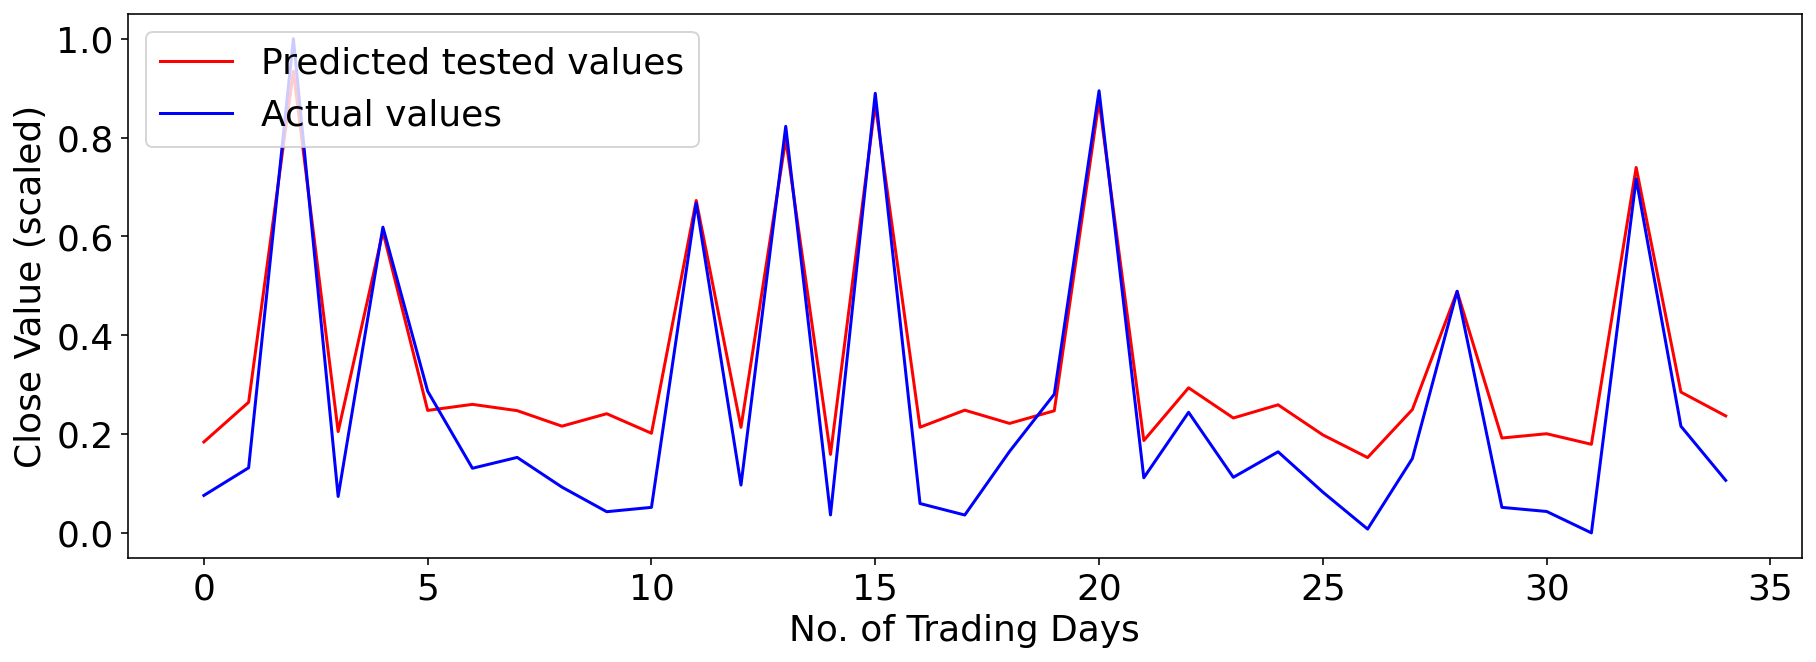

In [51]:
plt.plot(y_pred,color='red', label='Predicted tested values')
plt.plot(y_test.values, color='blue', label='Actual values')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [52]:
y_pred

array([[0.18400736],
       [0.26439184],
       [0.9340491 ],
       [0.2049897 ],
       [0.60955715],
       [0.24785513],
       [0.2600822 ],
       [0.24735644],
       [0.21594656],
       [0.24115583],
       [0.20160837],
       [0.67265743],
       [0.2136328 ],
       [0.79660225],
       [0.15882993],
       [0.86784816],
       [0.2138221 ],
       [0.24834603],
       [0.22153029],
       [0.24709363],
       [0.87437475],
       [0.18683818],
       [0.2935845 ],
       [0.23252854],
       [0.25917467],
       [0.1982847 ],
       [0.1524388 ],
       [0.24961883],
       [0.48865205],
       [0.19198044],
       [0.2006236 ],
       [0.17928505],
       [0.7393935 ],
       [0.2849265 ],
       [0.23670846]], dtype=float32)

In [56]:
from sklearn import metrics

print("R2:", metrics.r2_score(y_test, y_pred))

R2: 0.8542197614610662


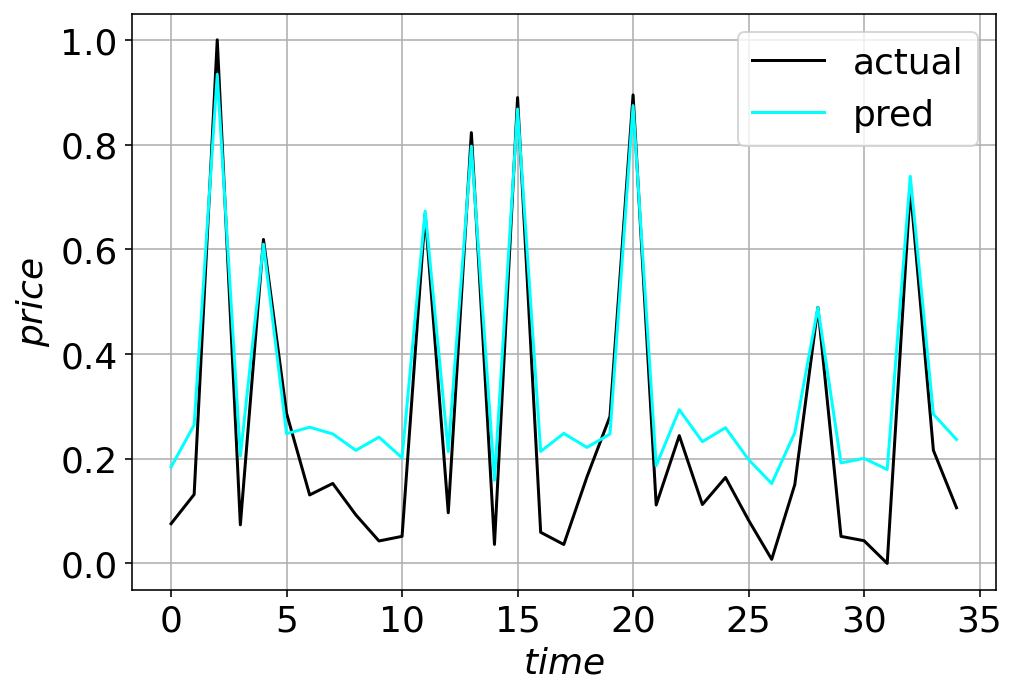

In [57]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(y_test, 'black')
ax.plot(y_pred, 'cyan')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])

fig.tight_layout()

plt.grid(True)
plt.show()

In [58]:
import inspect 
# Recall that you applied transformation functions, such as min max scaler and laber encoder. 
# Now you want to transform them back to human readable format.
feature_view.init_serving(1)
td_transformation_functions = feature_view._single_vector_server._transformation_functions

pred_y = pd.DataFrame(y_pred, columns=["close"])

for feature_name in td_transformation_functions:
    if feature_name == "close":
        td_transformation_function = td_transformation_functions[feature_name]
        sig, foobar_locals = inspect.signature(td_transformation_function.transformation_fn), locals()
        param_dict = dict([(param.name, param.default) for param in sig.parameters.values() if param.default != inspect._empty])
        if td_transformation_function.name == "min_max_scaler":
            pred_y[feature_name] = pred_y[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])
            y_test[feature_name] = y_test[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])

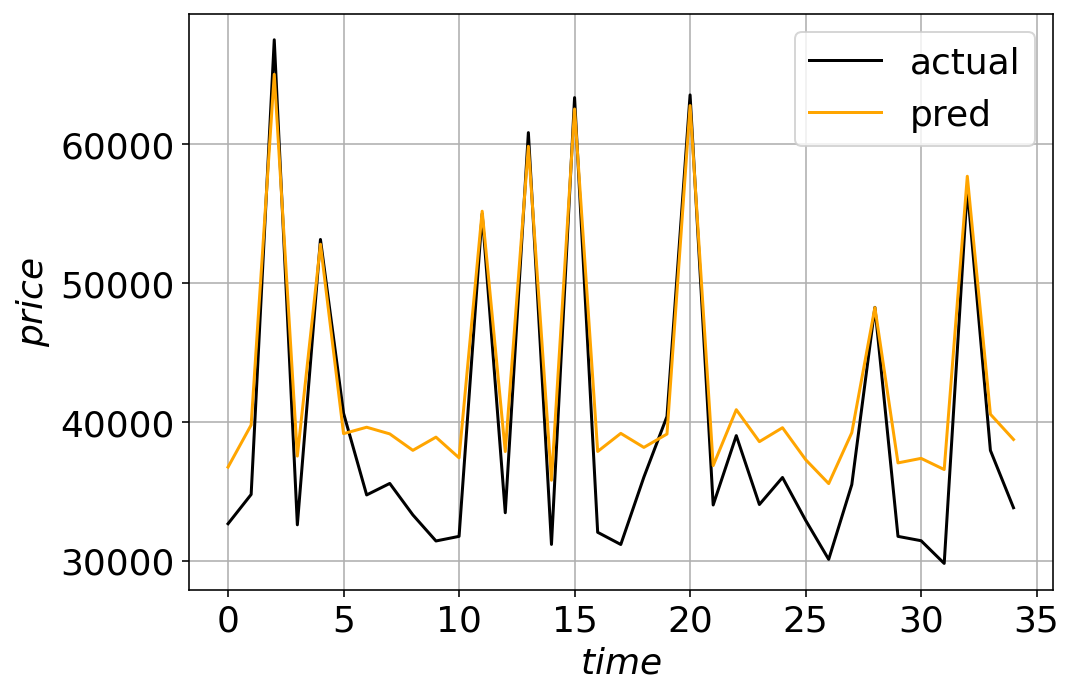

In [59]:
colors = ['darkslategrey']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.plot(y_test, 'black')
ax.plot(pred_y, 'orange')
ax.set_ylabel('$price$')
ax.set_xlabel('$time$')
ax.grid(True)
ax.legend(["actual", "pred"])

fig.tight_layout()

plt.grid(True)
plt.show()

---
## <span style='color:#ff5f27'>🗄 Model Registry</span>

In [48]:
export_path = "bitcoin_price_model"
print('Exporting trained model to: {}'.format(export_path))
    
tf.saved_model.save(model, export_path)

Exporting trained model to: bitcoin_price_model


In [59]:
mr = project.get_model_registry()
metrics={'loss': history_dict['val_mae'][0]} 

mr_model = mr.tensorflow.create_model(
    name="bitcoin_price_model",
    metrics=metrics,
    description="bitcoin daily price detection model.",
    input_example=X_test.sample()
)

Connected. Call `.close()` to terminate connection gracefully.


In [60]:
mr_model.save(export_path)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/1152/models/bitcoin_price_model/3


Model(name: 'bitcoin_price_model', version: 3)

---
## <span style="color:#ff5f27;">🚀 Model Deployment</span>

In [ ]:
%%writefile btc_model_transformer.py

import os
import hsfs
import numpy as np

class Transformer(object):
    
    def __init__(self):        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # get feature views
        self.fv = self.fs.get_feature_view("bitcoin_feature_view", 1)
        
        # initialise serving
        self.fv.init_serving(1)

    def flat2gen(self, alist):
        for item in alist:
            if isinstance(item, list):
                for subitem in item: yield subitem
            else:
                yield item
        
    def preprocess(self, inputs):
        feature_vector = self.fv.get_feature_vector({"unix": inputs["inputs"][0]})
        return { "inputs" :  np.array(list(self.flat2gen(feature_vector))).reshape(-1, 1, 34).tolist() }

    def postprocess(self, outputs):
        return outputs    

In [ ]:
import os
from hsml.transformer import Transformer
dataset_api = project.get_dataset_api()

uploaded_file_path = dataset_api.upload("btc_model_transformer.py", "Models", overwrite=True)
transformer_script_path = os.path.join("/Projects", project.name, uploaded_file_path)
transformer_script = Transformer(script_file=transformer_script_path)

In [51]:
# Use the model name from the previous notebook.
model = mr.get_model("bitcoin_price_model", version = 1)

In [ ]:
deployment = model.deploy(
    name="btcmodeldeployment",
    model_server="TENSORFLOW_SERVING", 
    serving_tool="KSERVE",
    transformer=transformer_script
)

The deployment has now been registered. Lets retrieve it from Hopsworks for demonstration purpose.

In [ ]:
ms = project.get_model_serving()

# get deployment object
deployment = ms.get_deployment("btcmodeldeployment")

In [ ]:
print("Deployment: " + deployment.name)
deployment.describe()

To start it you need to run:

In [ ]:
deployment.start()

For trouble shooting one can use get_logs method

In [ ]:
deployment.get_logs()

---
## <span style="color:#ff5f27;">🔮 Predicting</span>

Using the deployment let's use the input example that we registered together with the model to query the deployment.


In [ ]:
data = {
    "inputs": model.input_example
}
data

- 1663534800000
- 1664226000000
- 1663880400000
- 1664053200000

In [ ]:
deployment.predict(data)

In [ ]:
# For trouble shooting one you can use get_logs method.
deployment.get_logs()

---